# **CLASSIFICATION FINE-TUNING**

### **Downloading Dataset**


In [1]:
from urllib import request
import ssl
import zipfile
import os
from pathlib import Path

In [2]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam.zip"
extracted_path = "sms_spam"
file_path = Path(extracted_path)/"SMSSpamCollection.tsv"

def download_and_unzip_data(url, zip_path, extracted_path, file_path):
    if file_path.exists():
        print("File already exists")
        return

    ssl_context = ssl._create_unverified_context()

    with request.urlopen(url, context=ssl_context) as response:
      with open(zip_path, "wb") as zip_file:
        zip_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path)/"SMSSpamCollection"
    os.rename(original_file_path, file_path)

download_and_unzip_data(url, zip_path, extracted_path, file_path)

In [3]:
import pandas as pd

df = pd.read_csv(file_path, sep="\t", header=None, names=["label", "text"])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


In [6]:
def create_balanced_df(df):
  spam_count = df[df['label']=="spam"].shape[0]

  ham_subset = df[df['label']=="ham"].sample(spam_count, random_state=42)

  balanced_df = pd.concat([ham_subset, df[df['label']=="spam"]])

  return balanced_df

balanced_df = create_balanced_df(df)
balanced_df.head()

,label,text
3714,ham,If i not meeting ü all rite then i'll go home ...
1311,ham,"I.ll always be there, even if its just in spir..."
548,ham,"Sorry that took so long, omw now"
1324,ham,I thk 50 shd be ok he said plus minus 10.. Did...
3184,ham,Dunno i juz askin cos i got a card got 20% off...


In [7]:
print(balanced_df.shape)
balanced_df['label'].value_counts()

(1494, 2)


,count
label,
ham,747
spam,747


Next, we convert the "string" class labels "ham" and "spam" into integer class labels 0 and
1, respectively:

In [8]:
balanced_df['label'] = balanced_df['label'].map({"ham":0, "spam":1})
balanced_df

,label,text
3714,0,If i not meeting ü all rite then i'll go home ...
1311,0,"I.ll always be there, even if its just in spir..."
548,0,"Sorry that took so long, omw now"
1324,0,I thk 50 shd be ok he said plus minus 10.. Did...
3184,0,Dunno i juz askin cos i got a card got 20% off...
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [9]:
print(balanced_df.shape)
balanced_df['label'].value_counts()

(1494, 2)


,count
label,
0,747
1,747


In [10]:
from sklearn.model_selection import train_test_split

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df, val_df = train_test_split(balanced_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

print("Training Data Shape:", train_df.shape)
print("Validation Data Shape:", val_df.shape)
print("Testing Data Shape:", test_df.shape)

Training Data Shape: (1045, 2)
Validation Data Shape: (359, 2)
Testing Data Shape: (90, 2)


In [11]:
train_df.to_csv("train.csv", index=None)
val_df.to_csv("val.csv", index=None)
test_df.to_csv("test.csv", index=None)

### **Creating Dataloaders**

We first need to implement a PyTorch Dataset, which
specifies how the data is loaded and processed, before we can instantiate the data loaders.

In [12]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    self.encoded_texts = [
        tokenizer.encode(text) for text in self.data['text']
    ]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length

      self.encoded_texts = [
          encoded_text[:self.max_length] for encoded_text in self.encoded_texts
      ]

    self.encoded_texts = [
        encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
        for encoded_text in self.encoded_texts
    ]

  def __getitem__(self, index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]['label']
    return (
        torch.tensor(encoded, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
    )

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      if len(encoded_text) > max_length:
        max_length = len(encoded_text)
    return max_length

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset("train.csv", tokenizer, None)
test_dataset = SpamDataset("test.csv", tokenizer, max_length=train_dataset.max_length)
val_dataset = SpamDataset("val.csv", tokenizer, max_length=train_dataset.max_length)

In [14]:
print(train_dataset.max_length)
print(test_dataset.max_length)
print(val_dataset.max_length)

137
137
137


In [15]:
from torch.utils.data import DataLoader
torch.manual_seed(123)

num_workers = 0
batch_size = 16

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

In [16]:
for input_batch, target_batch in train_loader:
  pass

print("Input Batch Dimension:", input_batch.shape)
print("Target Batch Dimension:", target_batch.shape)

Input Batch Dimension: torch.Size([16, 137])
Target Batch Dimension: torch.Size([16])


In [17]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

65 training batches
23 validation batches
6 test batches


### **Initializing a model with pre-trained weights**

In [18]:
MODEL = "gpt2-small (124M)"
PROMPT = "I am a very upstanding"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.1,
    "qkv_bias": True
}

MODEL_CONFIG = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(MODEL_CONFIG[MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds context length {BASE_CONFIG['context_length']}"
    f"Reinitialize dataset with max_length={BASE_CONFIG['context_length']}"
)

In [19]:
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
    )

  def forward(self, x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, drop_rate, num_heads, qkv_bias):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(drop_rate)
    self.register_buffer("simple_mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    batch, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = torch.matmul(queries, keys.transpose(2, 3))

    attn_scores.masked_fill_(
        self.simple_mask.bool()[:num_tokens, :num_tokens],
        -torch.inf
    )

    attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)

    attn_weights = self.dropout(attn_weights)

    context_vec = torch.matmul(attn_weights, values)

    context_vec = context_vec.transpose(1, 2)

    context_vec = context_vec.contiguous().view(batch, num_tokens, self.d_out)

    context_vec = self.out_proj(context_vec)

    return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg['emb_dim'],
        d_out = cfg['emb_dim'],
        context_length = cfg['context_length'],
        num_heads = cfg['n_heads'],
        qkv_bias = cfg['qkv_bias'],
        drop_rate = cfg['drop_rate']
      )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    ## Connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    ## Conection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

class GPT_MODEL(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_out = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
    batch_size, seq_length = x.shape

    token_embeddings = self.token_emb(x)
    pos_embeddings = self.pos_emb(torch.arange(seq_length, device=x.device))

    x = token_embeddings + pos_embeddings
    x = self.drop_out(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):

    idx_crop = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_crop)

    logits = logits[:, -1, :]

    probas = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  token_list = token_ids.squeeze(0).tolist()
  decoded_text = tokenizer.decode(token_list)
  return decoded_text

def cal_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")

  elif num_batches is None:
    num_batches = len(data_loader)

  else:
    ## Reduce the number of batches to match the total number of batches in dataloader
    ## i.e if num_batches exceeds the number of the batches in data_loader
    num_batches = min(num_batches, len(data_loader))

  for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
    if batch_idx < num_batches:
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches

In [20]:
model_size = "124M"

from gpt_download3 import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size, models_dir="gpt2-124M")

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 150kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.70MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

In [21]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch: {left.shape} != {right.shape}")
  else:
    return torch.nn.Parameter(torch.tensor(right))

import numpy as np

def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
  gpt.token_emb.weight = assign(gpt.token_emb.weight, params["wte"])

  for b in range(len(params['blocks'])):
    q_w, k_w, v_w = np.split(
        (params['blocks'][b]['attn']['c_attn'])["w"], 3, axis=-1
    )
    gpt.trf_blocks[b].attn.W_query.weight = assign(gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
    gpt.trf_blocks[b].attn.W_key.weight = assign(gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
    gpt.trf_blocks[b].attn.W_value.weight = assign(gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

    q_b, k_b, v_b = np.split(
        (params['blocks'][b]['attn']['c_attn'])["b"], 3, axis=-1
    )
    gpt.trf_blocks[b].attn.W_query.bias = assign(gpt.trf_blocks[b].attn.W_query.bias, q_b)
    gpt.trf_blocks[b].attn.W_key.bias = assign(gpt.trf_blocks[b].attn.W_key.bias, k_b)
    gpt.trf_blocks[b].attn.W_value.bias = assign(gpt.trf_blocks[b].attn.W_value.bias, v_b)

    gpt.trf_blocks[b].attn.out_proj.weight = assign(gpt.trf_blocks[b].attn.out_proj.weight, params['blocks'][b]['attn']['c_proj']['w'].T)
    gpt.trf_blocks[b].attn.out_proj.bias = assign(gpt.trf_blocks[b].attn.out_proj.bias, params['blocks'][b]['attn']['c_proj']['b'])

    gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params['blocks'][b]['mlp']['c_fc']['w'].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params['blocks'][b]['mlp']['c_fc']['b'])

    gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params['blocks'][b]['mlp']['c_proj']['w'].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params['blocks'][b]['mlp']['c_proj']['b'])

    gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params['blocks'][b]['ln_1']['g'])
    gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params['blocks'][b]['ln_1']['b'])

    gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params['blocks'][b]['ln_2']['g'])
    gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params['blocks'][b]['ln_2']['b'])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [22]:
model = GPT_MODEL(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPT_MODEL(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_out): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_featu

In [23]:
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(PROMPT, tokenizer),
    max_new_tokens=30,
    context_size=BASE_CONFIG['context_length']
)

print(token_ids_to_text(token_ids, tokenizer))

I am a very upstanding person and I am very proud of my family. I am very proud of my family and I am very proud of my family. I am very proud


In [24]:
text = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text, tokenizer),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive


### **Modifying the architecture by adding a Classification Head**

We will only fine-tune 3 layers or components:

- Final Output Head
- Final LayerNorm
- Final Transformer Block

To get the model ready for classification-finetuning, we first freeze the model, meaning that
we make all layers non-trainable:

In [25]:
for param in model.parameters():
  param.requires_grad = False

Then, we replace the output layer (model.out_head), which
originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary)

In [26]:
torch.manual_seed(123)

num_classes = 2
model.out_head = nn.Linear(BASE_CONFIG['emb_dim'], out_features=num_classes)

- This new model.out_head output layer has its requires_grad attribute set to True by
default, which means that it's the only layer in the model that will be updated during
training.
- Additionally, we configure the last transformer block and the final LayerNorm module,
which connects this block to the output layer, to be trainable

In [27]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [28]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0)
print("Inputs:", inputs)
print("Input Dimension:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Input Dimension: torch.Size([1, 4])


In [29]:
with torch.no_grad():
  logits = model(inputs)

print("Logits:", logits)
print("Logits Dimension:", logits.shape)

Logits: tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Logits Dimension: torch.Size([1, 4, 2])


We will only consider the last row, since it contains attention scores of all previous words

In [30]:
print("Last Output Token:", logits[:, -1, :])

Last Output Token: tensor([[-3.5983,  3.9902]])


In [31]:
probas = torch.softmax(logits[:, -1, :], dim=-1)
print(probas)
labels = torch.argmax(probas)
print("Class Label:", labels.item())

tensor([[5.0598e-04, 9.9949e-01]])
Class Label: 1


### **Calculating the loss function and accuracy**



To determine the classification accuracy, we apply the argmax-based prediction code to
all examples in the dataset and calculate the proportion of correct predictions by defining a
calc_accuracy_loader function

In [32]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :]

      predicted_labels = torch.argmax(logits, dim=-1)

      num_examples += predicted_labels.shape[0]
      correct_predictions += (predicted_labels == target_batch).sum().item()

    else:
      break

  accuracy = correct_predictions / num_examples
  return accuracy

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, 8)
test_accuracy = calc_accuracy_loader(test_loader, model, device, 8)
val_accuracy = calc_accuracy_loader(val_loader, model, device, 8)

print("Train Accuracy:", train_accuracy*100)
print("Test Accuracy:", test_accuracy*100)
print("Validation Accuracy:", val_accuracy*100)

Train Accuracy: 48.4375
Test Accuracy: 52.22222222222223
Validation Accuracy: 44.53125


In [35]:
def cal_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

In [36]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0

  if len(data_loader) == 0:
    return float("nan")

  elif num_batches is None:
    num_batches = len(data_loader)

  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()

    else:
      break

  return total_loss / num_batches

In [38]:
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, 8)
  test_loss = calc_loss_loader(test_loader, model, device, 8)
  val_loss = calc_loss_loader(val_loader, model, device, 8)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Validation Loss:", val_loss)

Train Loss: 2.669733300805092
Test Loss: 2.4408263564109802
Validation Loss: 2.857151120901108


### **Fine-Tuning the model on Supervised Data**

- Step 1: Set model to training mode
- Step 2: Reset loss gradients from previous batch iteration
- Step 3: Calculate loss gradients
- Step 4: Update model weights using loss gradients
- Step 5: New: track examples instead of tokens
- Step 6: Optional evaluation step
- Step 7: Calculate accuracy after each epoch

In [40]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
  train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
  examples_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1} (Step {global_step:06d}): "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    train_accuracy = calc_accuracy_loader(train_loader, model, device, eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, eval_iter)
    print(f"Train Accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%)")
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

  return train_losses, val_losses, train_accuracies, val_accuracies, examples_seen

In [41]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()

  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)

  model.train()

  return train_loss, val_loss

In [50]:
import time
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs =  5

train_losses, val_losses, train_accuracies, val_accuracies, examples_seen = train_classifier_simple(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    device = device,
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 16
)

end_time = time.time()
total_time = (end_time - start_time) / 60
print(f"Total Training Time: {total_time:.2f} seconds")

Epoch 1 (Step 000000): Train Loss: 0.4582, Val Loss: 0.4764
Epoch 1 (Step 000050): Train Loss: 0.5363, Val Loss: 0.5415
Train Accuracy: 86.33% | Validation Accuracy: 82.81%)
Epoch 2 (Step 000100): Train Loss: 0.4132, Val Loss: 0.4218
Train Accuracy: 83.20% | Validation Accuracy: 81.25%)
Epoch 3 (Step 000150): Train Loss: 0.4012, Val Loss: 0.3720
Train Accuracy: 87.89% | Validation Accuracy: 86.33%)
Epoch 4 (Step 000200): Train Loss: 0.3576, Val Loss: 0.3796
Epoch 4 (Step 000250): Train Loss: 0.3282, Val Loss: 0.3150
Train Accuracy: 89.06% | Validation Accuracy: 88.28%)
Epoch 5 (Step 000300): Train Loss: 0.2933, Val Loss: 0.2597
Train Accuracy: 91.80% | Validation Accuracy: 92.19%)
Total Training Time: 1.85 seconds


In [51]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend(loc="best")

  ax2 = ax1.twiny()   ## Creates a second x-axis that shares the same y-axis
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")

  fig.tight_layout()
  plt.show()

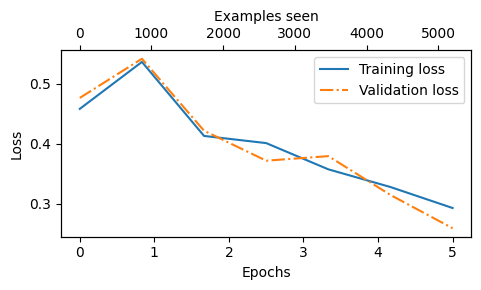

In [53]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

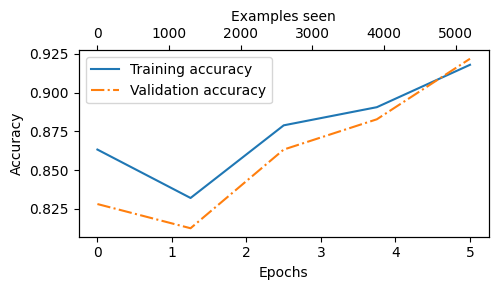

In [54]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accuracies))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accuracies))

plot_values(epochs_tensor, examples_seen_tensor, train_accuracies, val_accuracies, label="accuracy")

In [55]:
train_accuracy = calc_accuracy_loader(train_loader, model, device, 8)
test_accuracy = calc_accuracy_loader(test_loader, model, device, 8)
val_accuracy = calc_accuracy_loader(val_loader, model, device, 8)

print("Train Accuracy:", train_accuracy*100)
print("Test Accuracy:", test_accuracy*100)
print("Validation Accuracy:", val_accuracy*100)

Train Accuracy: 92.96875
Test Accuracy: 85.55555555555556
Validation Accuracy: 91.40625


### **Testing the Fine-Tuned Model**

In [63]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
  model.eval()

  input_ids = tokenizer.encode(text)
  context_length = model.pos_emb.weight.shape[0]

  input_ids = input_ids[:min(max_length, context_length)]

  input_ids += [pad_token_id] * (max_length - len(input_ids))

  input_tensors = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)

  with torch.no_grad():
    logits = model(input_tensors)[:, -1, :]    ## to get logits of last output token

  predicted_label = torch.argmax(logits, dim=-1).item()
  print(predicted_label)
  label = "spam" if predicted_label == 1 else "not spam"

  return label

In [69]:
txt = "Contact me as soon as possible"

label = classify_review(txt, model, tokenizer, device, train_dataset.max_length)
print(label)

0
not spam


In [72]:
txt = "SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"

label = classify_review(txt, model, tokenizer, device, train_dataset.max_length)
print(label)

1
spam


In [73]:
torch.save(model.state_dict(), "model.pth")

In [74]:
model_state_dict = torch.load("model.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>